In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['y_train.csv', 'sample_submission.csv', 'X_test.csv', 'X_train.csv']


In [2]:
# load all data 
train = pd.read_csv('../input/X_train.csv')
#tr = pd.read_csv('../input/career-con-2019/X_train.csv')
sub = pd.read_csv('../input/sample_submission.csv')
test = pd.read_csv('../input/X_test.csv')
target = pd.read_csv('../input/y_train.csv')

In [3]:
# check the series number and measurement number
series_n = len(train.series_id.value_counts())
measurement_n = len(train.measurement_number.value_counts())
s_m = pd.DataFrame(train.groupby(['series_id'])['measurement_number'].agg('count'))
print("There are "+ str(series_n)+' unique series_id')
print("Each series_id has "+ str(measurement_n)+' unique measurement_number')
s_m.head() 
# each series_id has 128 meansurement_number, and there is 3810 unique series_id which equal to target row number

There are 3810 unique series_id
Each series_id has 128 unique measurement_number


,measurement_number
series_id,
0,128
1,128
2,128
3,128
4,128


In [4]:
# check missing data in train
totalt = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Total', 'Percent'])
print ("Missing Data at Training")
missing_data.head()

Missing Data at Training


,Total,Percent
linear_acceleration_Z,0,0.0
linear_acceleration_Y,0,0.0
linear_acceleration_X,0,0.0
angular_velocity_Z,0,0.0
angular_velocity_Y,0,0.0


In [5]:
# check missing data in target
totalt_target = target.isnull().sum().sort_values(ascending=False)
percent_target = (target.isnull().sum()/target.isnull().count()).sort_values(ascending=False)
missing_data_target = pd.concat([totalt_target, percent_target], axis=1, keys=['Total', 'Percent'])
print ("Missing Data at Target")
missing_data_target

Missing Data at Target


,Total,Percent
surface,0,0.0
group_id,0,0.0
series_id,0,0.0


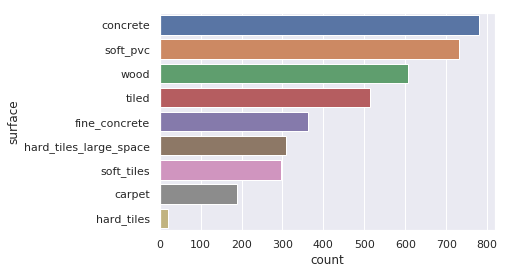

In [6]:
# check group_id and surface in target data
sns.set(style='darkgrid')
sns.countplot(y = 'surface',
              data = target,
              order = target['surface'].value_counts().index)
plt.show()

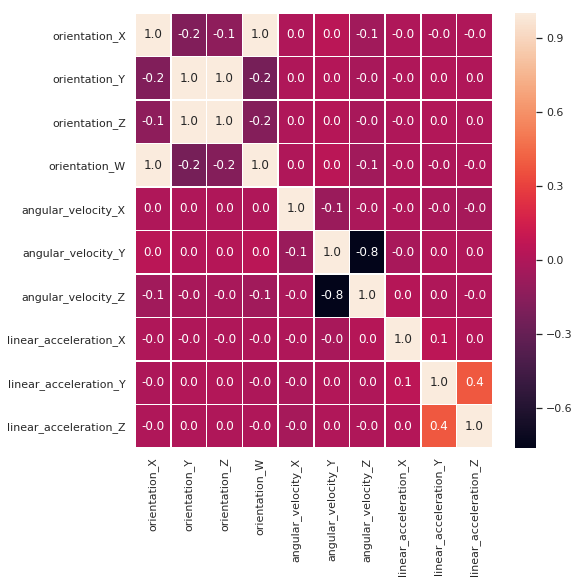

In [7]:
# check the correlation between 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(train.iloc[:,3:].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
# looks like there are some really important pair correlation 

In [8]:
# combine the train and target
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
target['surface'] = le.fit_transform(target['surface'])

final_d = pd.merge(train,target,on="series_id")
features = final_d.columns[3:13]
t = final_d[features]
result = final_d['surface']
train_x,val_x,train_y,val_y = train_test_split(t,result,random_state=1,train_size=0.8)

In [ ]:
# baseline model 
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(train_x,train_y)
rf_pred = rf.predict(val_x)
rf_accuracy = accuracy_score(val_y, rf_pred)
print(classification_report(rf_pred,val_y))
print("Baseline model accuracy is " + str(round(rf_accuracy,3)))

In [ ]:
# run the model function
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=59)
predicted = np.zeros((test.shape[0],9))
measured= np.zeros((t.shape[0]))
score = 0

for times, (trn_idx, val_idx) in enumerate(folds.split(t.values,final_d['surface'].values)):
    model = RandomForestClassifier(n_estimators=200, n_jobs = -1)
    #model = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=5, n_jobs=-1)
    model.fit(t.iloc[trn_idx],final_d['surface'][trn_idx])
    measured[val_idx] = model.predict(t.iloc[val_idx])
    predicted += model.predict_proba(test[features])/folds.n_splits
    score += model.score(t.iloc[val_idx],final_d['surface'][val_idx])
    print("Fold: {} score: {}".format(times,model.score(t.iloc[val_idx],final_d['surface'][val_idx])))

    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = t.columns
    
    if model.score(t.iloc[val_idx],final_d['surface'][val_idx]) > 0.92000:
        hm = 30
        plt.figure(figsize=(7, 10))
        plt.title('Feature Importances')
        plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
        plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

In [ ]:
print('Avg Accuracy RF', score / folds.n_splits)

In [ ]:
import time
import datetime
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=59)
predicted = np.zeros((test.shape[0],9))
measured= np.zeros((t.shape[0]))
score = 0

params = {'num_leaves': 123,
          'min_data_in_leaf': 12,
          'objective': 'multiclass',
          'max_depth': 22,
          'learning_rate': 0.04680350949723872,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8933018355190274,
          "bagging_seed": 11,
          "verbosity": -1,
          'reg_alpha': 0.9498109326932401,
          'reg_lambda': 0.8058490960546196,
          "num_class": 9,
          'nthread': -1,
          'min_split_gain': 0.009913227240564853,
          'subsample': 0.9027358830703129
         }

for times, (trn_idx, val_idx) in enumerate(folds.split(t.values,final_d['surface'].values)):
    model = lgb.LGBMClassifier(**params, n_estimators = 200, n_jobs = -1)
    #model = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=5, n_jobs=-1)
    model.fit(t.iloc[trn_idx],final_d['surface'][trn_idx])
    measured[val_idx] = model.predict(t.iloc[val_idx])
    predicted += model.predict_proba(test[features])/folds.n_splits
    score += model.score(t.iloc[val_idx],final_d['surface'][val_idx])
    print("Fold: {} score: {}".format(times,model.score(t.iloc[val_idx],final_d['surface'][val_idx])))

    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = t.columns
    
    if model.score(t.iloc[val_idx],final_d['surface'][val_idx]) > 0.92000:
        hm = 30
        plt.figure(figsize=(7, 10))
        plt.title('Feature Importances')
        plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
        plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

In [ ]:
le.classes_
from sklearn.metrics import confusion_matrix
confusion_matrix(final_d['surface'], measured)

In [ ]:
# new model as function
import time
import datetime
import lightgbm as lgb
import xgboost as xgb
def eval_acc(preds, dtrain):
    labels = dtrain.get_label()
    return 'acc', accuracy_score(labels, preds.argmax(1)), True

def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, 
                model=None):

    oof = np.zeros((len(X), 9))
    prediction = np.zeros((len(X_test), 9))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X.values, y.values)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators = 10000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='multi_logloss',
                    verbose=5000, early_stopping_rounds=200)
            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, 
                              verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), 
                                         ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
        
        oof[valid_index] = y_pred_valid
        scores.append(accuracy_score(y_valid, y_pred_valid.argmax(1)))
        prediction += y_pred    
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index
            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

In [ ]:
params = {'num_leaves': 123,
          'min_data_in_leaf': 12,
          'objective': 'multiclass',
          'max_depth': 22,
          'learning_rate': 0.04680350949723872,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8933018355190274,
          "bagging_seed": 11,
          "verbosity": -1,
          'reg_alpha': 0.9498109326932401,
          'reg_lambda': 0.8058490960546196,
          "num_class": 9,
          'nthread': -1,
          'min_split_gain': 0.009913227240564853,
          'subsample': 0.9027358830703129
         }


oof_lgb, prediction_lgb, feature_importance = train_model(X=t, X_test=test[features], y=result, 
                                                          params=params, model_type='lgb', plot_feature_importance=True)

In [ ]:
# submit and summary
from scipy import stats
p = predicted.argmax(axis=1).reshape((3816, 128))
ss = []
for i in range(3816):
    ss.append(stats.mode(p[i,:])[0])
sub['surface'] = le.inverse_transform(ss)
sub.to_csv('submission.csv', index=False)
sub.head()

In [9]:
# Try FC-NN model 
from keras.models import Sequential
from keras.layers import Dense

# xx is the train data as DataFrame with (390144, 10), row is number of samples and column is number of features 
# In here number of features also correspond to input_dim for first NN layer
xx = train_x

# Output is muti-class thus train_y have to convert to one-hot encoding
yy = pd.get_dummies(train_y).values

model = Sequential()

# Add an input layer 
model.add(Dense(16, activation='relu',input_dim = 10))

# Add another input layer 
model.add(Dense(12, activation='relu'))

# Add another input layer 
model.add(Dense(12, activation='relu'))

# Add another input layer 
model.add(Dense(8, activation='relu'))

# Add an output layer 
model.add(Dense(9, activation='softmax')) # output 9 correspond to number of predicted class

Using TensorFlow backend.


In [10]:
# compile model and run the model 
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(xx, yy, epochs = 100,validation_data=(val_x,pd.get_dummies(val_y).values))
# Also for evaluate, val_y have to change to one-hot encoding dummy variable 
model.evaluate(val_x,pd.get_dummies(val_y).values)

Train on 390144 samples, validate on 97536 samples
Epoch 1/100
390144/390144 [==============================] - 21s 53us/step - loss: 1.6671 - acc: 0.3679 - val_loss: 1.4816 - val_acc: 0.4504
Epoch 2/100
390144/390144 [==============================] - 20s 51us/step - loss: 1.4189 - acc: 0.4703 - val_loss: 1.3653 - val_acc: 0.5030
Epoch 3/100
390144/390144 [==============================] - 20s 50us/step - loss: 1.3149 - acc: 0.5266 - val_loss: 1.2982 - val_acc: 0.5253
Epoch 4/100
390144/390144 [==============================] - 19s 50us/step - loss: 1.2382 - acc: 0.5585 - val_loss: 1.2126 - val_acc: 0.5684
Epoch 5/100
390144/390144 [==============================] - 19s 50us/step - loss: 1.1832 - acc: 0.5768 - val_loss: 1.1852 - val_acc: 0.5830
Epoch 6/100
390144/390144 [==============================] - 19s 49us/step - loss: 1.1374 - acc: 0.5944 - val_loss: 1.1114 - val_acc: 0.6046
Epoch 7/100
390144/390144 [==============================] - 19s 49us/step - loss: 1.0989 - acc: 0.6088

390144/390144 [==============================] - 18s 47us/step - loss: 0.7329 - acc: 0.7319 - val_loss: 0.7400 - val_acc: 0.7254
Epoch 59/100
390144/390144 [==============================] - 18s 47us/step - loss: 0.7317 - acc: 0.7314 - val_loss: 0.7443 - val_acc: 0.7230
Epoch 60/100
390144/390144 [==============================] - 18s 47us/step - loss: 0.7277 - acc: 0.7332 - val_loss: 0.7207 - val_acc: 0.7342
Epoch 61/100
390144/390144 [==============================] - 18s 47us/step - loss: 0.7270 - acc: 0.7328 - val_loss: 0.7187 - val_acc: 0.7332
Epoch 62/100
390144/390144 [==============================] - 18s 47us/step - loss: 0.7239 - acc: 0.7334 - val_loss: 0.7232 - val_acc: 0.7334
Epoch 63/100
390144/390144 [==============================] - 19s 48us/step - loss: 0.7226 - acc: 0.7343 - val_loss: 0.7061 - val_acc: 0.7430
Epoch 64/100
390144/390144 [==============================] - 19s 47us/step - loss: 0.7217 - acc: 0.7346 - val_loss: 0.7111 - val_acc: 0.7442
Epoch 65/100
390144

[0.6821208388258623, 0.7471292650918635]

In [ ]:
model.summary()